Note: while these packages are not required for the use of MorphLink, they are used
here to demonstrate the functionality of the package with real data and integration
with multiple other packages. This tutorial requires:

- `CAVEclient`,
- `skeletor`,
- `pcg_skel`,
- `pyvista`,

all of which are available on PyPI.


## Initialization

Start a CAVEclient


In [2]:
from caveclient import CAVEclient

client = CAVEclient("minnie65_public")

Create a `MorphLink` instance. This is the object we'll use for keeping track of
different features and representations of morphology.


In [3]:
from morphlink import MorphLink

morphology = MorphLink()

## Adding a mesh

We'll start by getting the morphology of a single neuron as a mesh.


In [4]:
root_id = 864691135361314119

cv = client.info.segmentation_cloudvolume()
mesh = cv.mesh.get(root_id)[root_id]

We can add this to our morphology representation using the `add_mesh` method.


In [5]:
morphology.add_mesh(mesh, "mesh")
morphology.layers

layer layer_type
name                                                            
mesh  Mesh(vertices=(2652062, 3), faces=(5293626, 3))       Mesh

## Adding point annotations

Next, we can add the nucleus location for this neuron. This is a new type of layer,
in this case just a single point.


In [6]:
nuc_info = client.materialize.query_table(
    "nucleus_detection_v0",
    filter_equal_dict={"pt_root_id": root_id},
    split_positions=True,
    desired_resolution=[1, 1, 1],
)
nuc_loc = nuc_info[["pt_position_x", "pt_position_y", "pt_position_z"]].values.squeeze()
nuc_loc

array([725760., 491456., 853080.])

In [7]:
morphology.add_points(nuc_loc, "nucleus")

In [8]:
morphology.layers

layer layer_type
name                                                               
mesh     Mesh(vertices=(2652062, 3), faces=(5293626, 3))       Mesh
nucleus                            Points(points=(1, 3))     Points

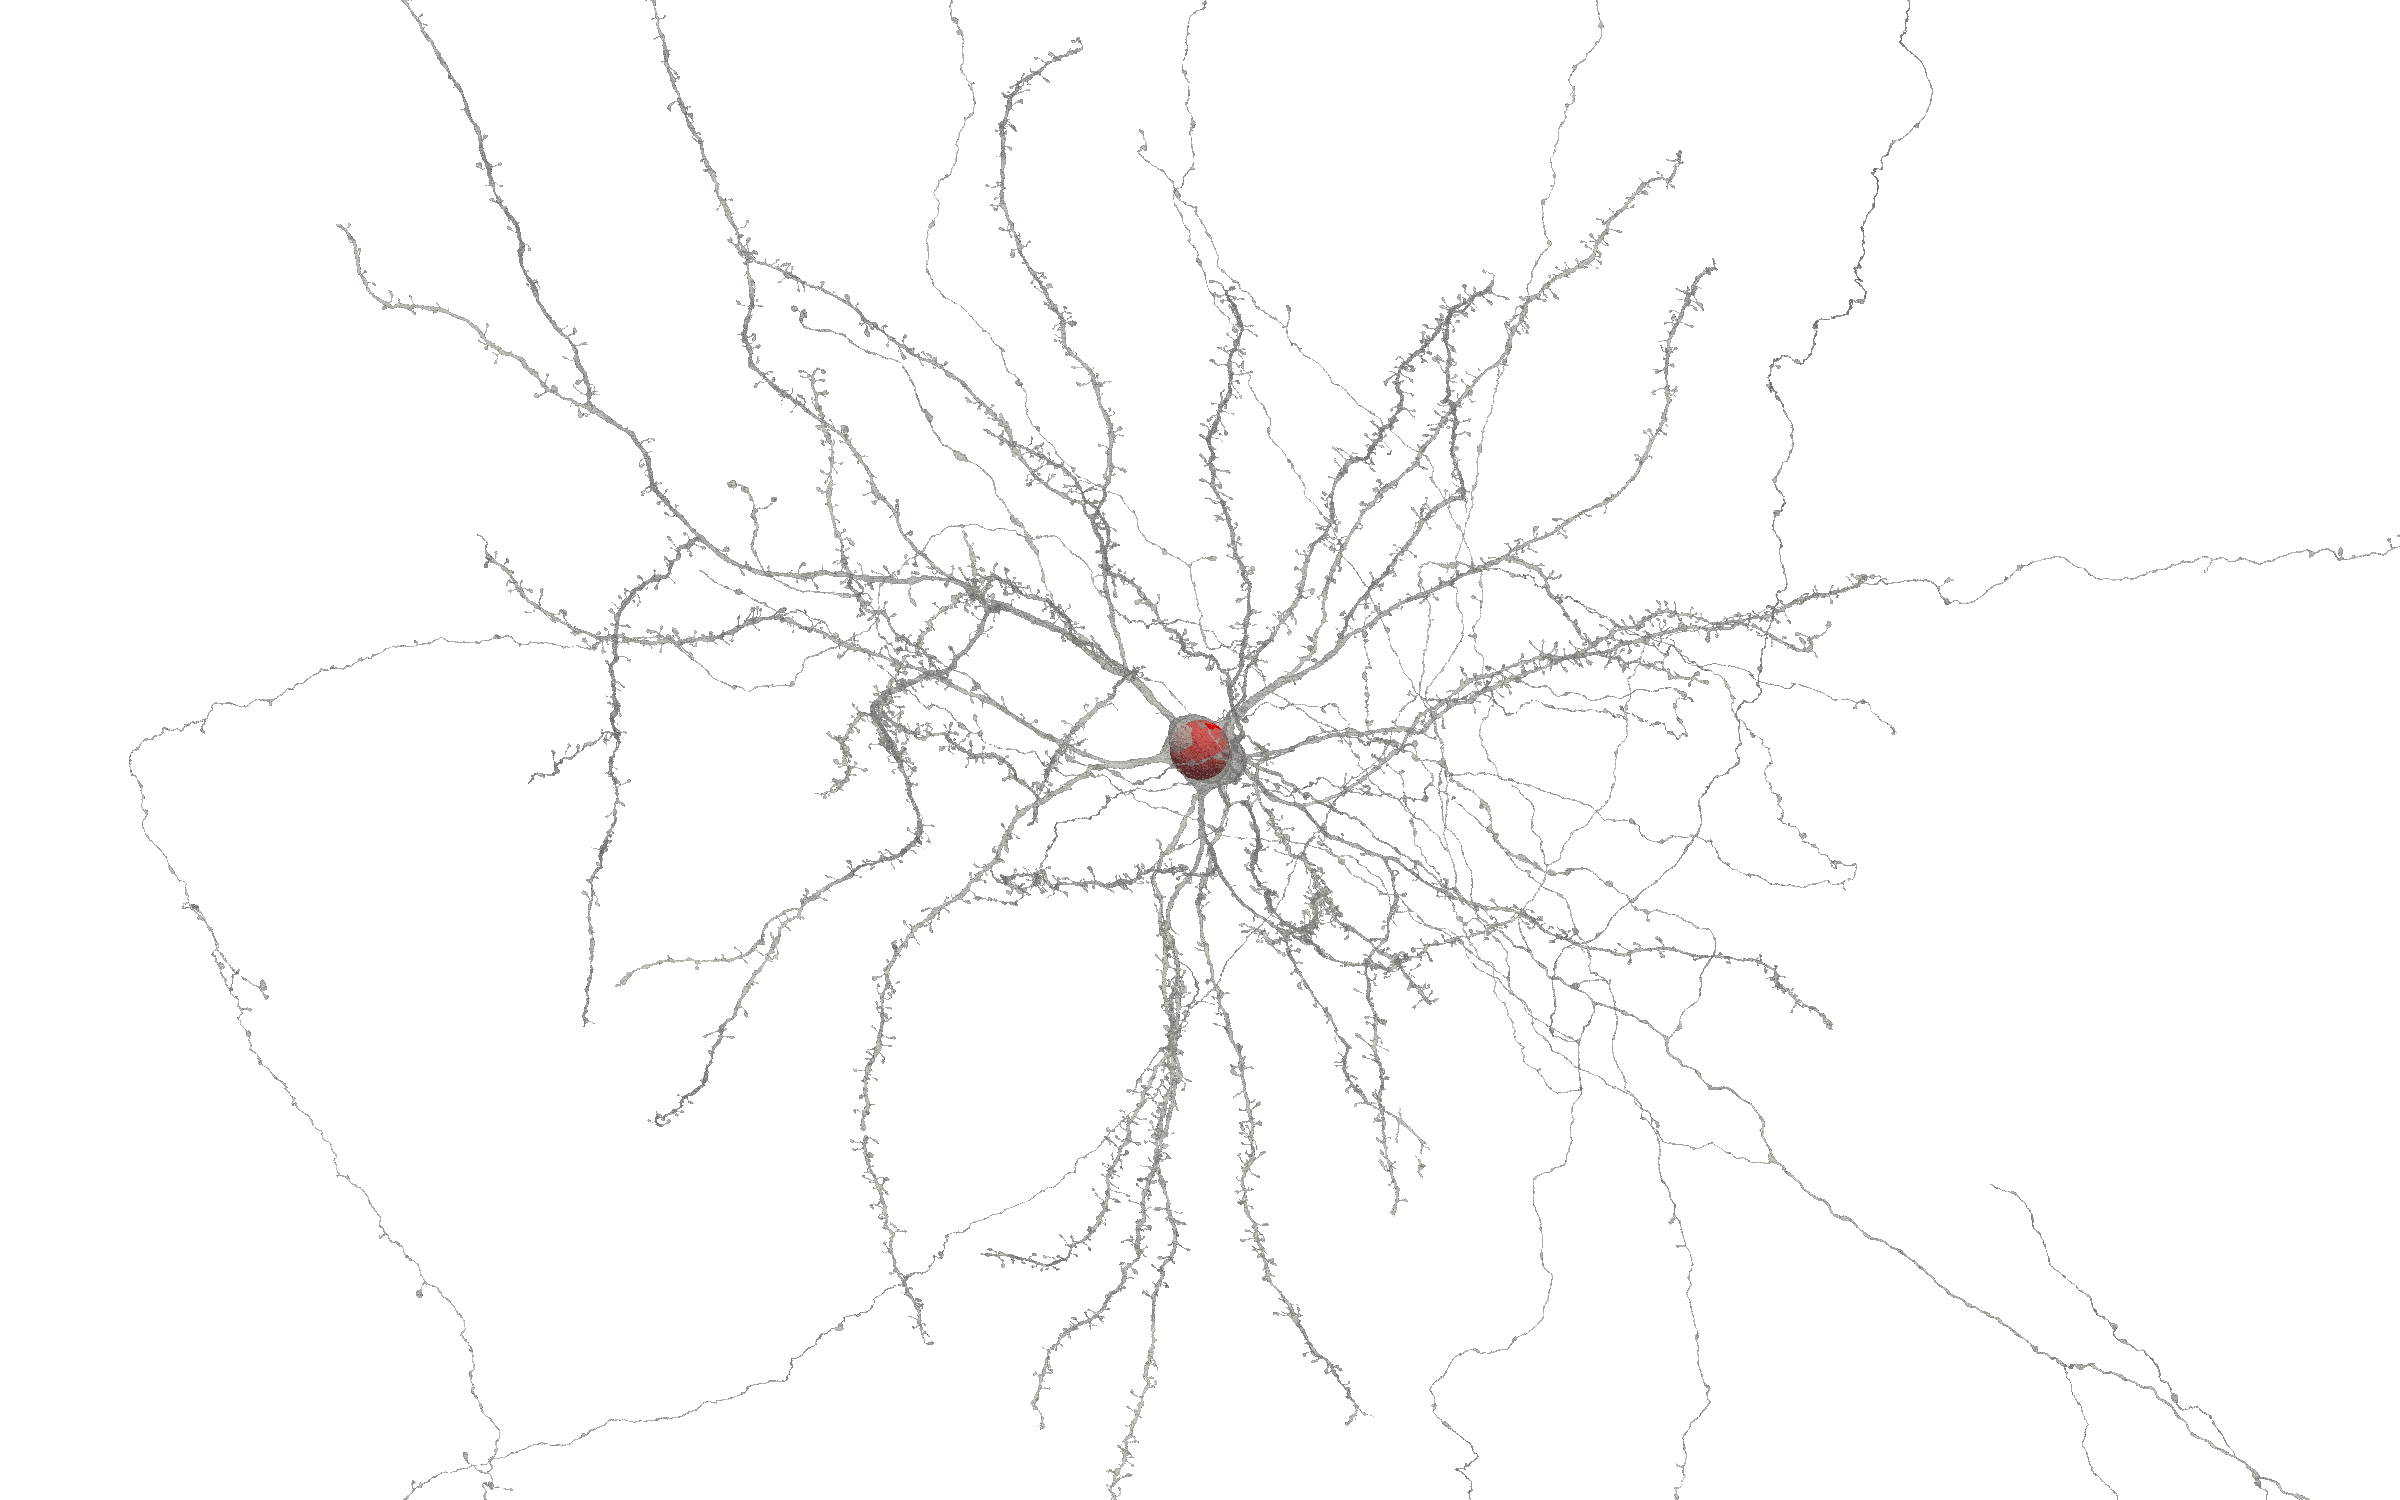

In [28]:
polydatas = morphology.to_pyvista()

import pyvista as pv

WINDOW_SIZE = [2400, 1500]
pv.set_jupyter_backend("static")
plotter = pv.Plotter(window_size=WINDOW_SIZE)
plotter.add_mesh(polydatas["mesh"], color="lightgrey", opacity=0.5)
plotter.add_points(
    polydatas["nucleus"], color="red", point_size=60, render_points_as_spheres=True
)
plotter.camera.focal_point = nuc_loc
plotter.camera.zoom(5)
plotter.show()

Similarly, we can add another layer that consists of many points - in this case,
synapses onto this neuron.


In [29]:
post_synapses = client.materialize.query_table(
    "synapses_pni_2",
    filter_equal_dict={"post_pt_root_id": root_id},
    split_positions=True,
    desired_resolution=[1, 1, 1],
)
post_synapses.set_index("id", inplace=True)

By setting the `spatial_columns` argument, we can specify which columns in the
DataFrame correspond to spatial coordinates. This allows future methods to do
space-aware operations on this layer. In the example above for the nucleus, the
spatial columns were inferred since we passed in a 3-dimensional array.


In [30]:
morphology.add_points(
    post_synapses,
    "post_synapses",
    spatial_columns=["ctr_pt_position_x", "ctr_pt_position_y", "ctr_pt_position_z"],
)

Now, let's link some of these objects together. The simplest mapping is to
annotate the nucleus location on the mesh. Under the hood, the `add_link` method
will find the closest point on the mesh and save that mapping.


In [31]:
morphology.add_link("nucleus", "mesh")

morphology.links

link
source  target                                         
nucleus mesh       nucleus     mesh
0        0  1220064

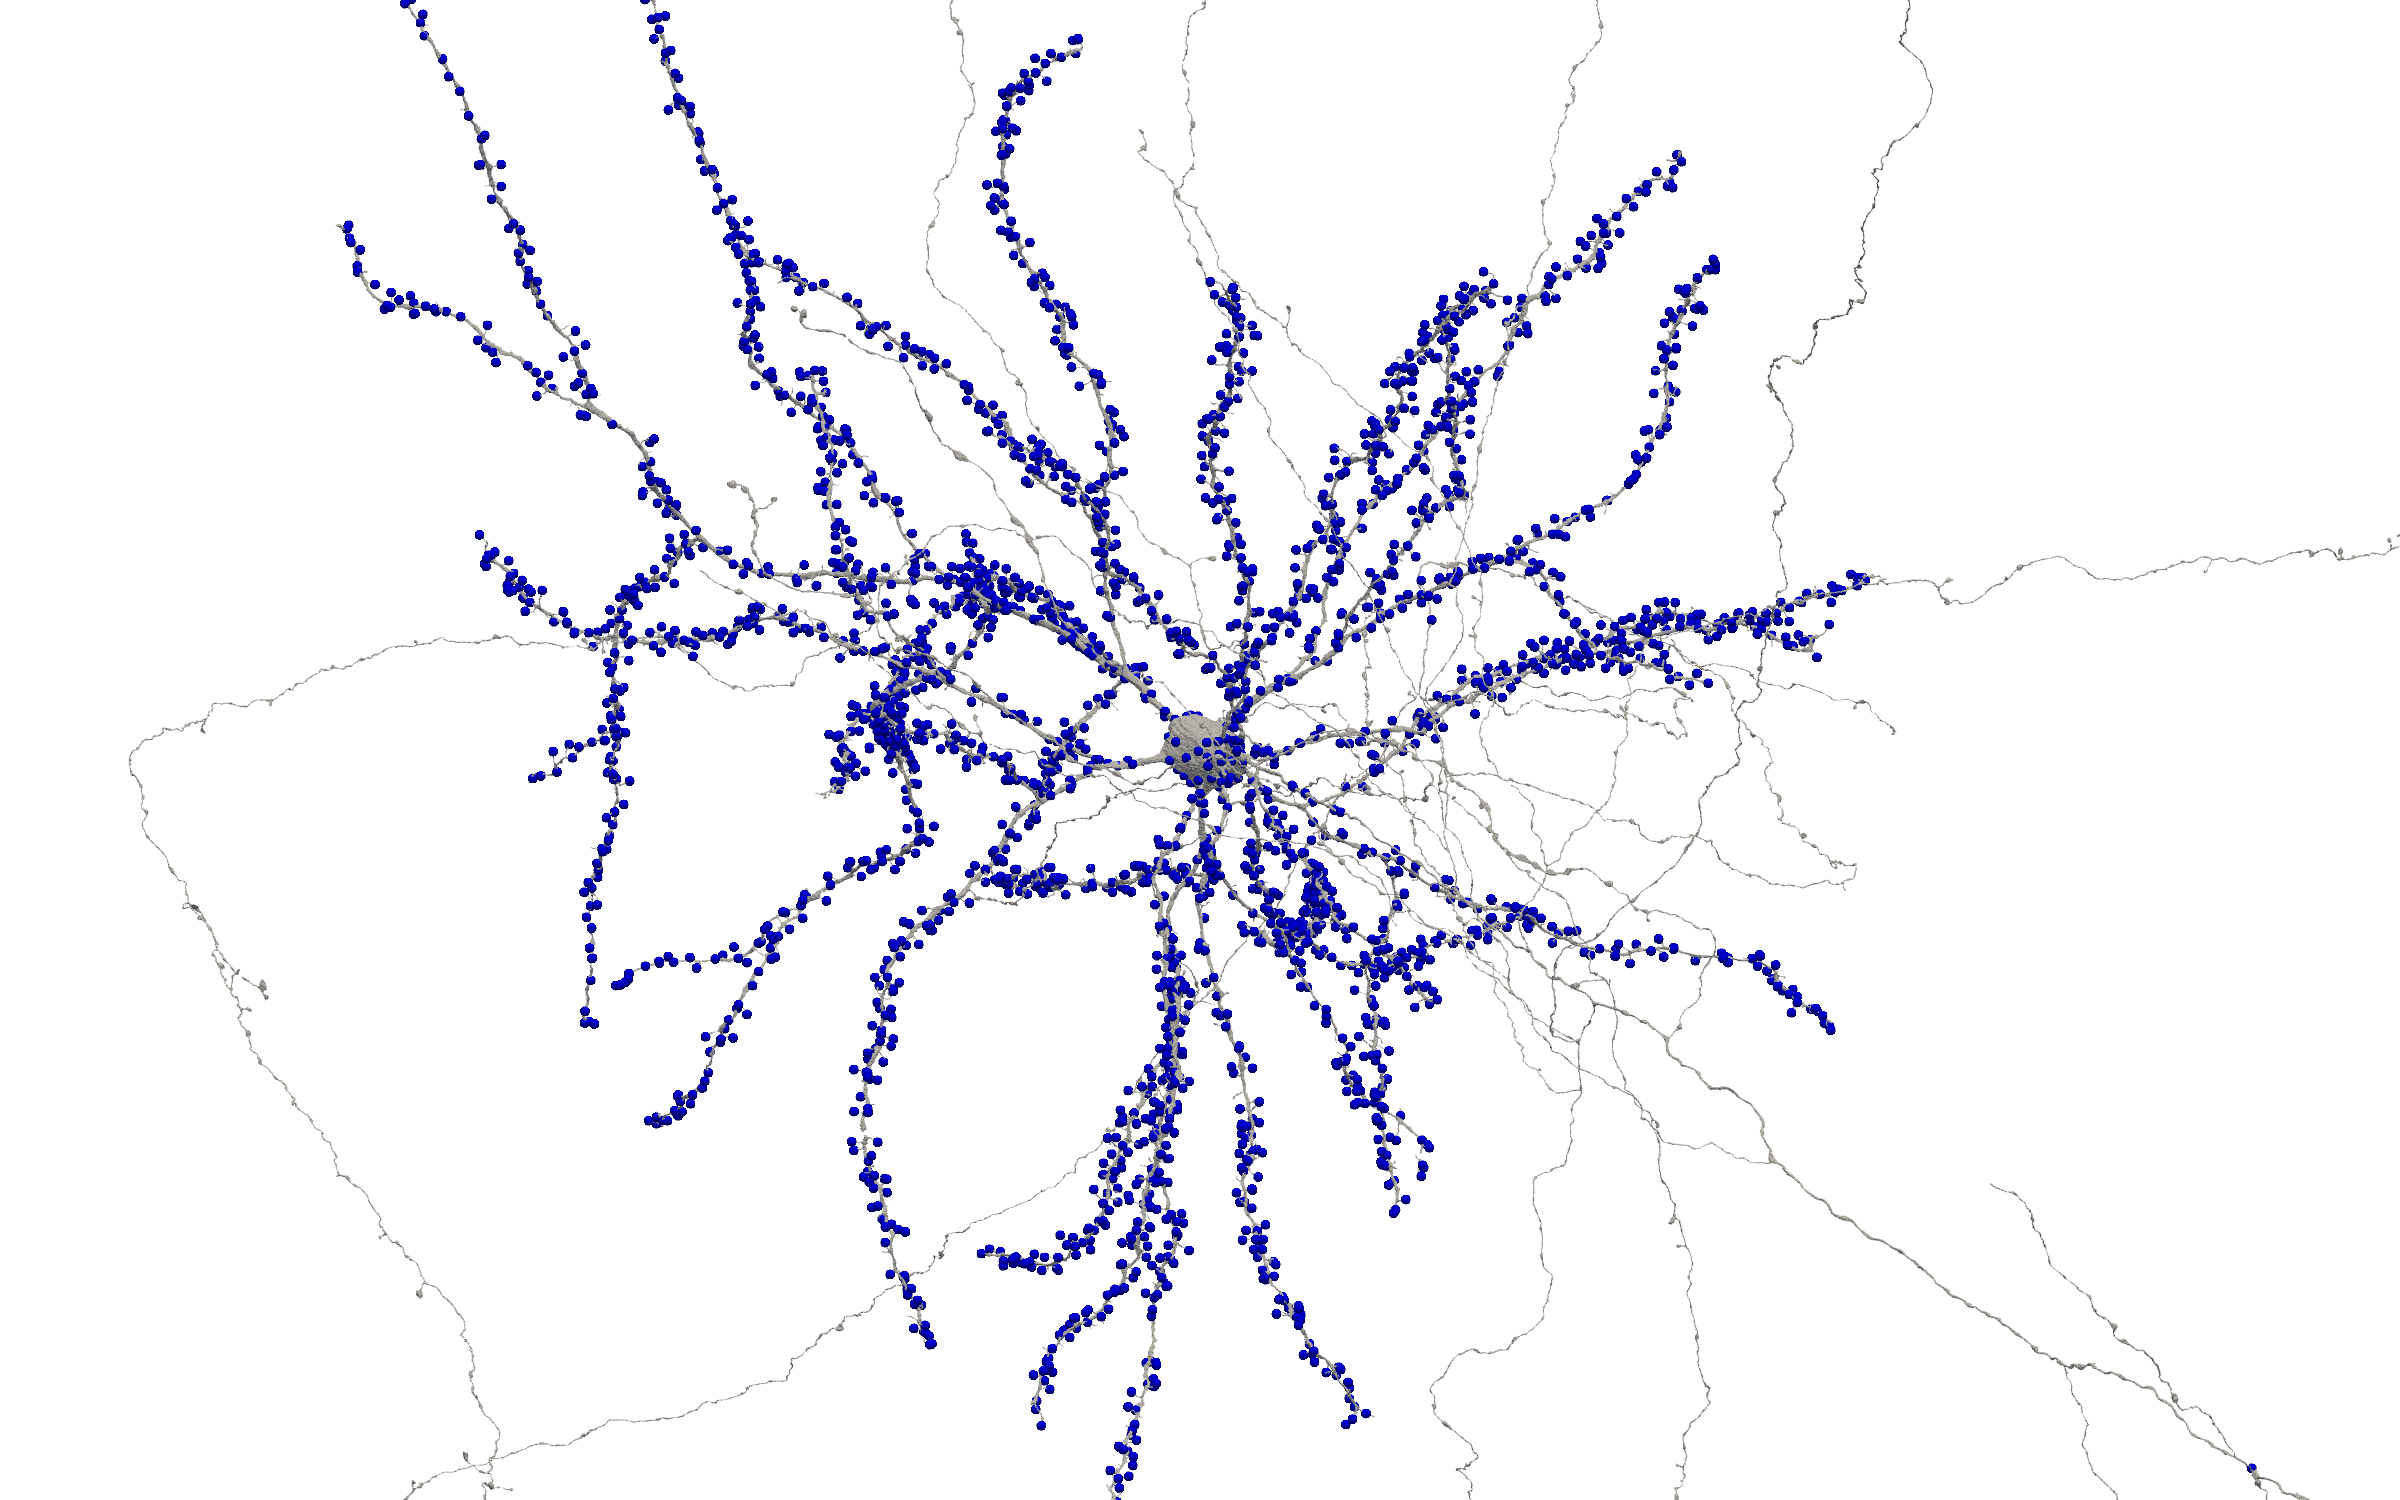

In [35]:
plotter = pv.Plotter(window_size=WINDOW_SIZE)
plotter.add_mesh(polydatas["mesh"], color="lightgrey")
plotter.add_points(
    morphology.post_synapses.to_pyvista(),
    color="blue",
    point_size=10,
    render_points_as_spheres=True,
)
plotter.camera.focal_point = nuc_loc
plotter.camera.zoom(5)
plotter.show()

Again, we can do this for synapses as well, here again finding the closest point on
the mesh for each synapse.


In [36]:
morphology.add_link("post_synapses", "mesh")

morphology.links

link
source        target                                                   
nucleus       mesh                 nucleus     mesh
0        0  1220064
post_synapses mesh          post_synapses     mesh
0         1873158...

We can retreive the mapping between the nucleus and the mesh using the
`get_link` method. This returns a DataFrame with the mapping as its two columns.


In [37]:
morphology.get_link("nucleus", "mesh")

nucleus     mesh
0        0  1220064

We can also ask for the specific mapping for a point in our nucleus layer. Since we
only have one point in this layer, we just get one item back from the mapping, denoting
the closest point on the mesh.


In [38]:
mesh_nuc_index = morphology.get_mapping("nucleus", "mesh")

mesh_nuc_index

Index([1220064], dtype='int64', name='mesh')

## Adding a skeleton

Now, we can do something a bit more interesting. Let's skeletonize the mesh, using
the nucleus as the source points for the skeletonization.

Note: requires `skeletor` package to be installed.


In [39]:
import time

from skeletor.skeletonize import by_wavefront

currtime = time.time()

out = by_wavefront(mesh, origins=mesh_nuc_index.to_list(), progress=True)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

Skeletonizing:   0%|          | 0/2652062 [00:00<?, ?it/s]

26.028 seconds elapsed.


This skeletonization process stores the mapping between mesh vertices and the new,
collapsed vertices from the skeletonization. First, let's add the skeleton to our
morphology representations.


In [40]:
morphology.add_graph(out, "skeleton")

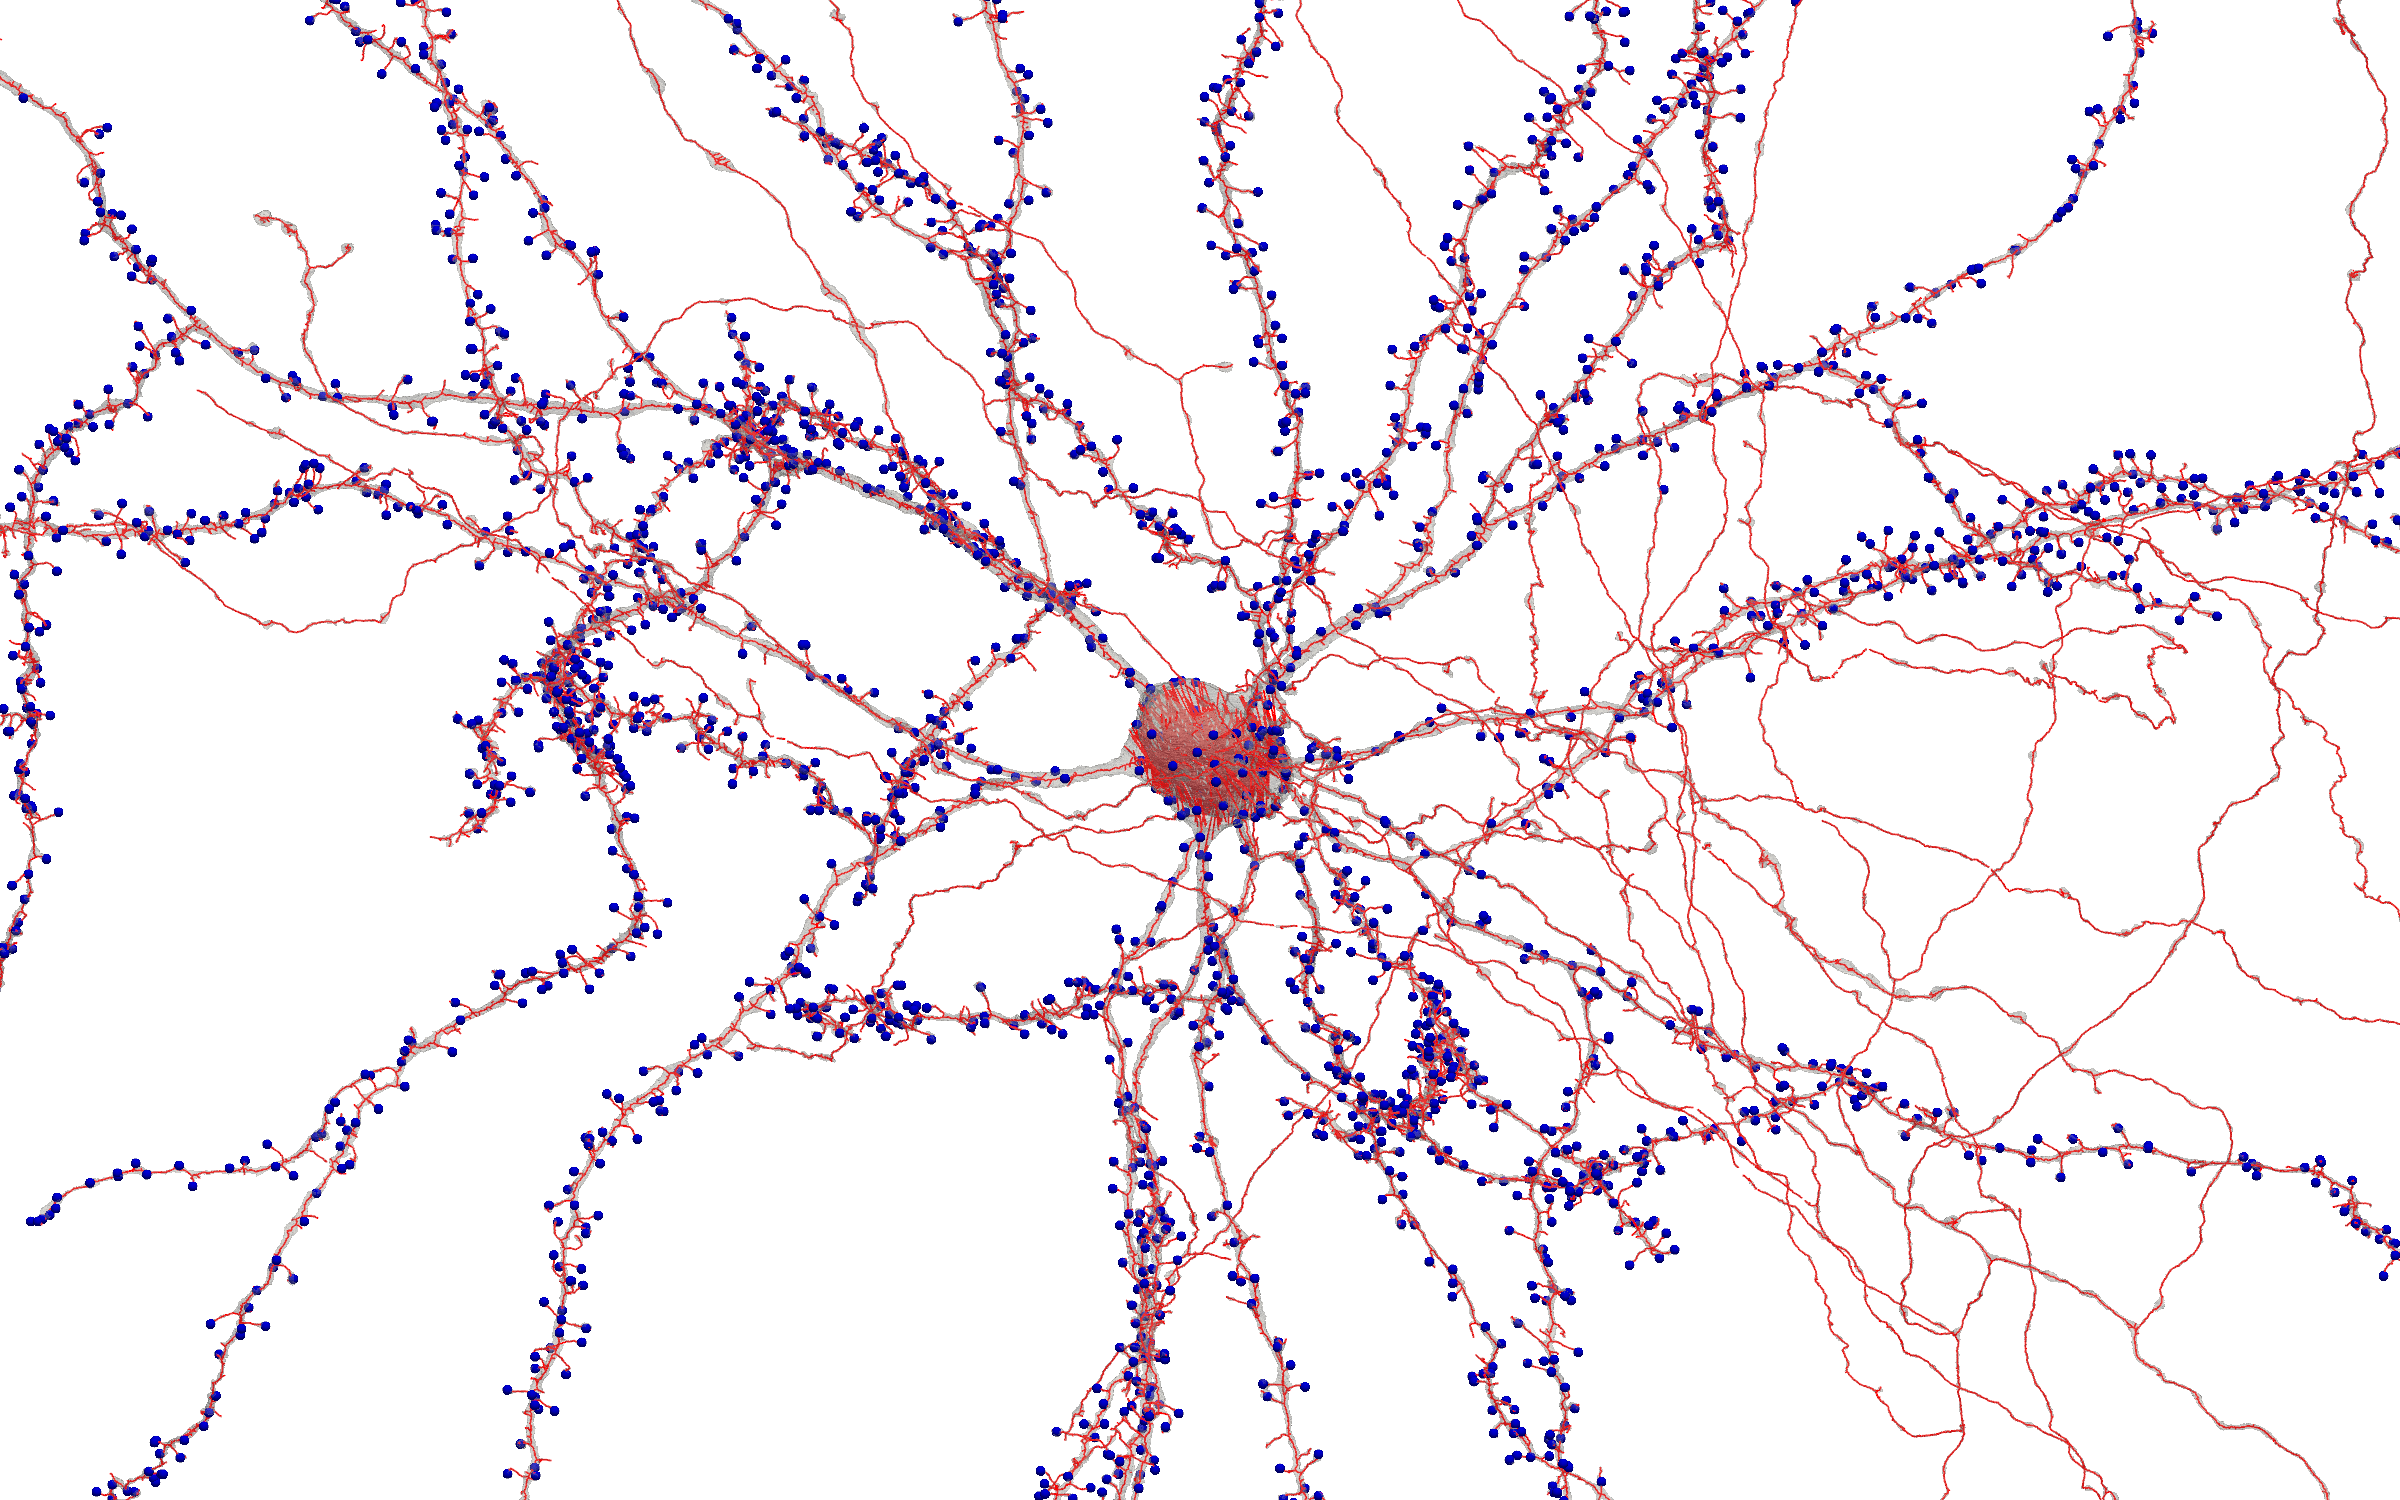

In [44]:
plotter = pv.Plotter(window_size=WINDOW_SIZE)
plotter.add_mesh(morphology.mesh.to_pyvista(), color="lightgrey", opacity=0.3)
plotter.add_mesh(
    morphology.post_synapses.to_pyvista(),
    color="blue",
    point_size=10,
    render_points_as_spheres=True,
)
plotter.add_mesh(morphology.skeleton.to_pyvista(), color="red", line_width=2)
plotter.camera.focal_point = nuc_loc
plotter.camera.zoom(10)
plotter.show()

Then, we can add the mapping between the mesh and the skeleton. This mapping is
stored in the `mesh_map` attribute of the skeletonization output.


In [45]:
morphology.add_link("mesh", "skeleton", mapping=out.mesh_map)

In [46]:
morphology.links

link
source        target                                                     
nucleus       mesh                   nucleus     mesh
0        0  1220064
post_synapses mesh            post_synapses     mesh
0         1873158...
mesh          skeleton              mesh  skeleton
0              0   ...

## More complex mappings

Now, we might also be interested in where synapses are located along the skeleton.
Even though the skeletonization map doesn't have a direct mapping between the mesh
and the synapses, we can first map synapses to their points on the mesh, and then
map those mesh points to their points on the skeleton.

Fortunately, this kind of transitive mapping is handled automatically by MorphLink
under the hood. Internally, there is a graph that denotes relationships between
different layers, and the `link_path` method can be used to find the path from a
source layer to a target layer (if one exists).

Many times, this will just be a direct link.


In [47]:
morphology.get_link_path("post_synapses", "mesh")

['post_synapses', 'mesh']

But as in the case of the synapses and the skeleton, it will find the path that
involves mapping synapses to the mesh, and then the mesh to the skeleton.


In [48]:
morphology.get_link_path("post_synapses", "skeleton")

['post_synapses', 'mesh', 'skeleton']

In [49]:
synapse_skeleton_ids = morphology.get_mapping("post_synapses", "skeleton")
synapse_skeleton_ids

Index([124839,  64175, 121215, 115029,  54276,  10115,  46720, 114390, 103022,
        53731,
       ...
        48629, 123062,  46546, 133495, 116864,  27888,  71817,  67137, 116485,
       116624],
      dtype='int64', name='skeleton', length=3216)

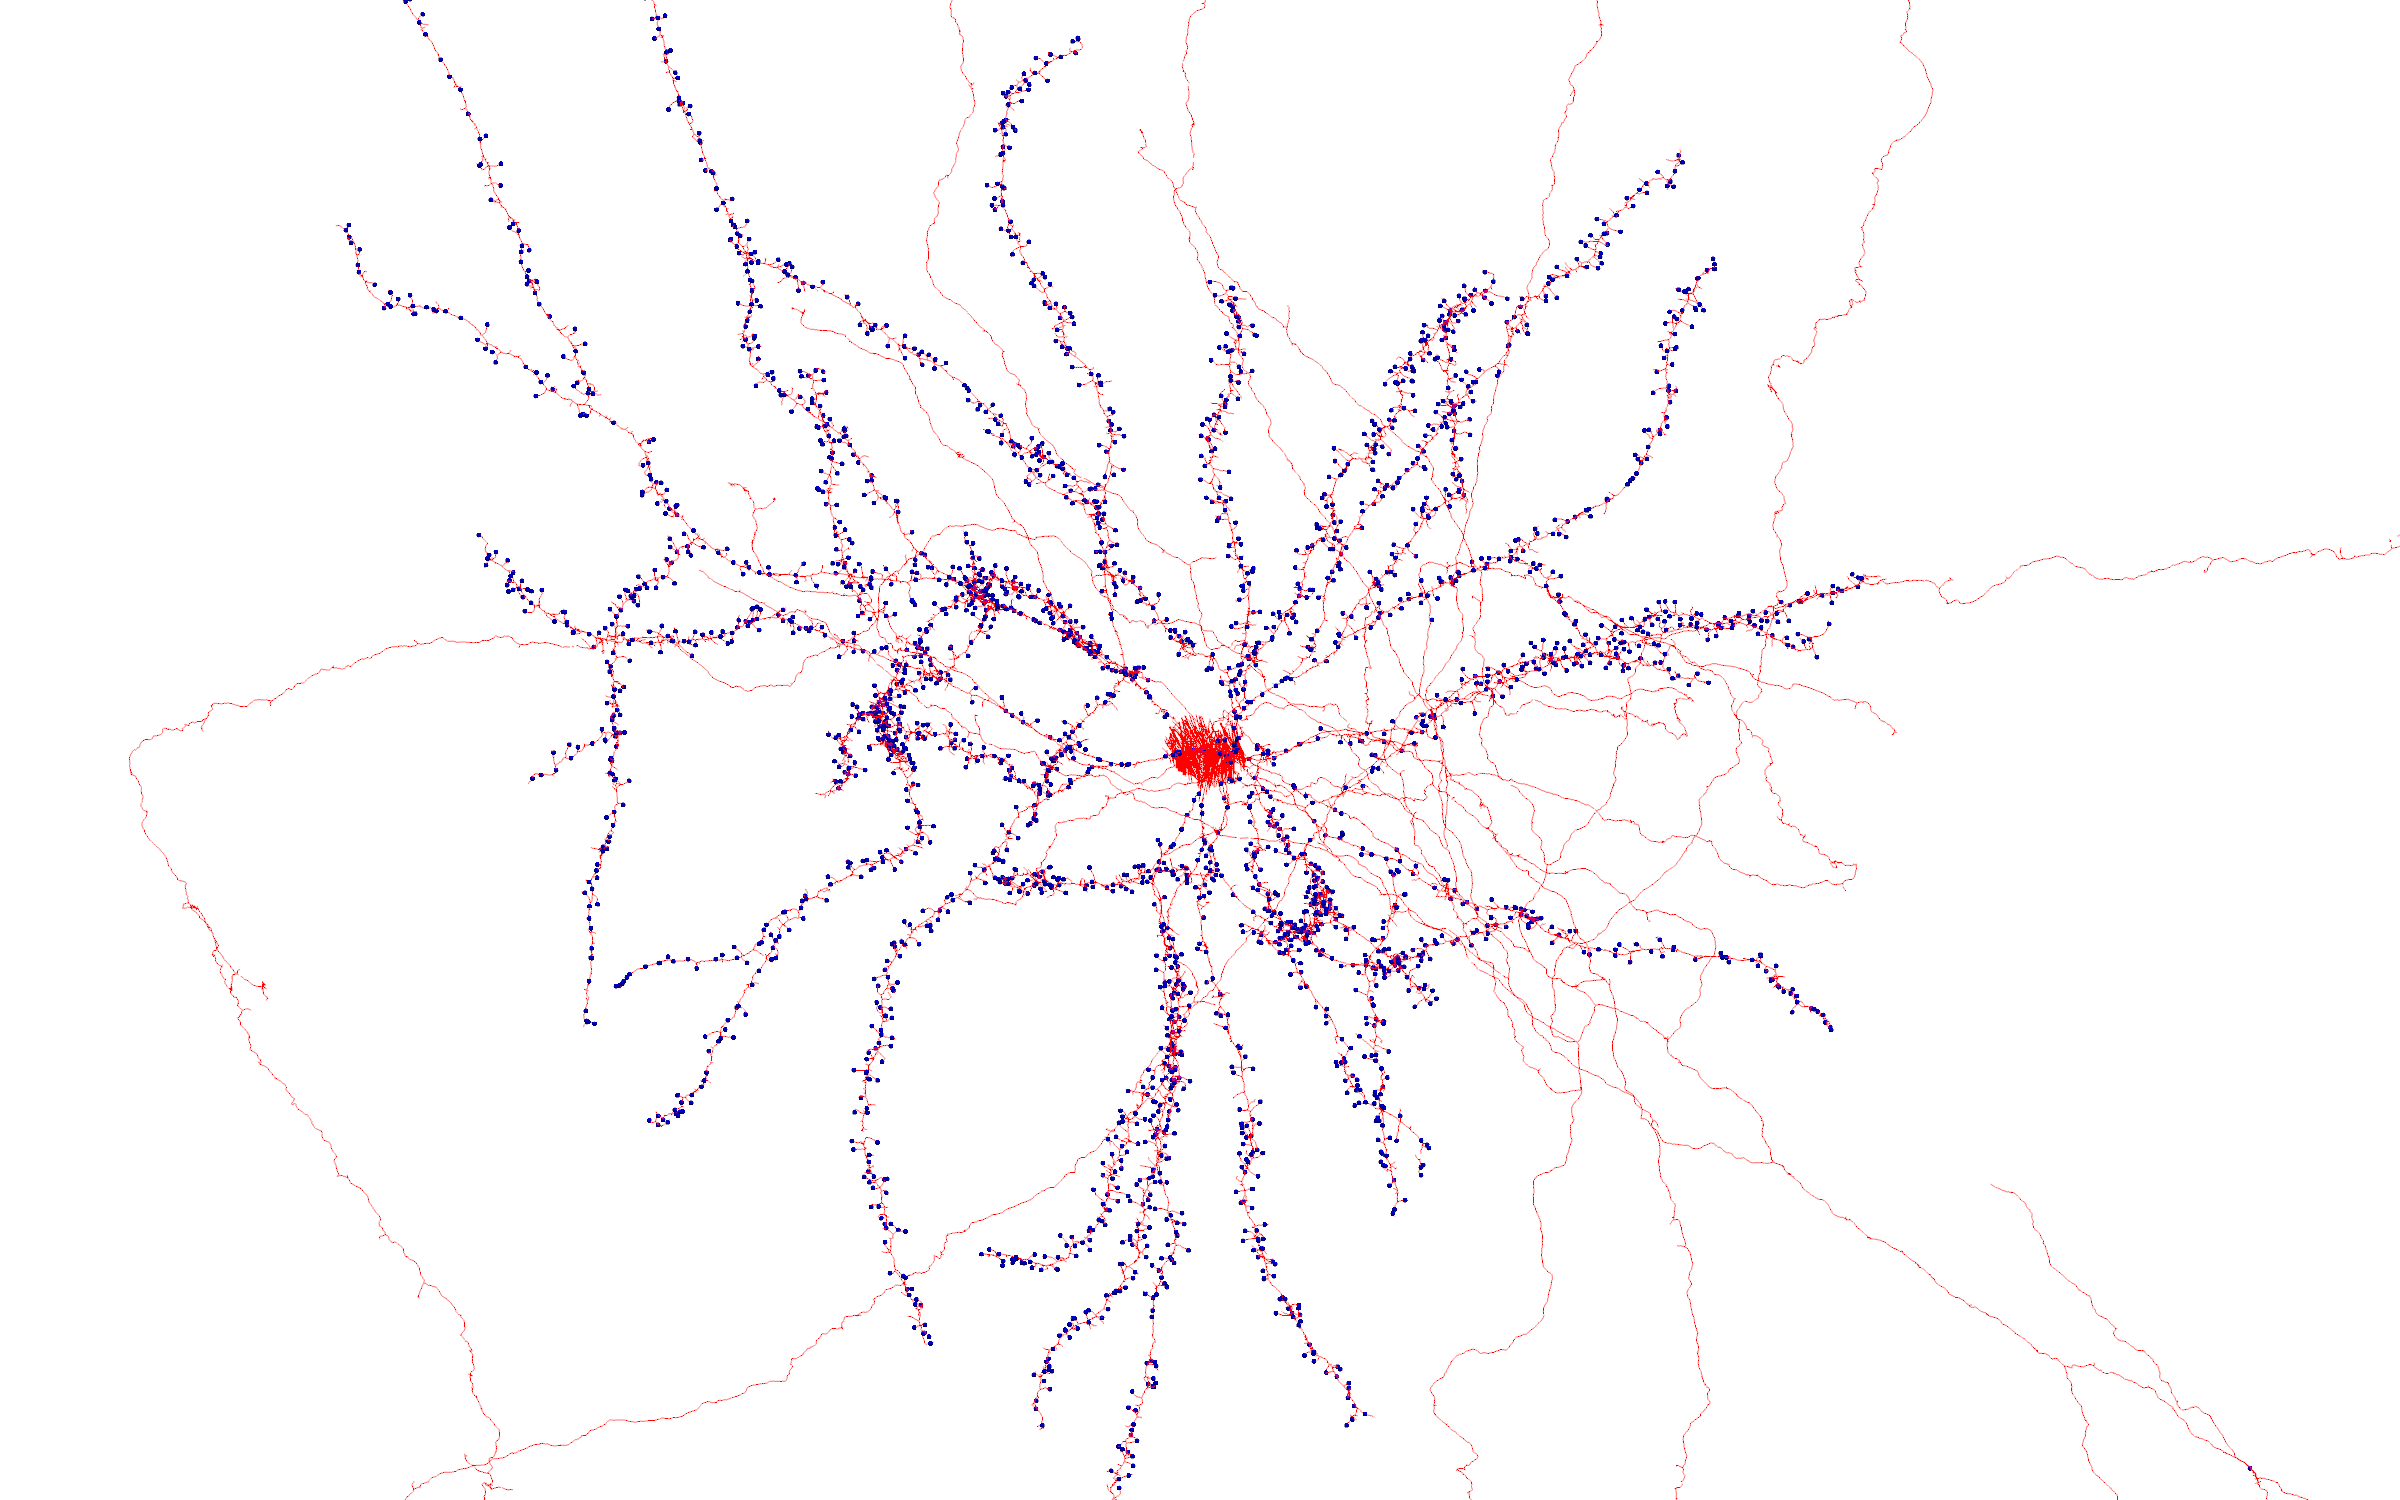

In [53]:
skeleton_synapse_points = morphology.skeleton.nodes.iloc[synapse_skeleton_ids]

plotter = pv.Plotter(window_size=WINDOW_SIZE)
plotter.add_mesh(morphology.skeleton.to_pyvista(), color="red", line_width=1)
plotter.add_points(
    skeleton_synapse_points.values,
    color="blue",
    point_size=5,
    render_points_as_spheres=True,
)
plotter.camera.focal_point = nuc_loc
plotter.camera.zoom(5)
plotter.show()